In [22]:
import discopy
import lambeq
from discopy.grammar.pregroup import Ty, Word, Cup, Diagram
from discopy.quantum import Circuit, sqrt, Ket, H, CX, SWAP,Bra, CRx, Rx
from pytket.extensions.qiskit import tk_to_qiskit, AerBackend
import numpy as np
from discopy import CircuitFunctor, qubit
from collections import defaultdict
from nltk.tokenize import word_tokenize
from random import shuffle
import random

In [23]:
parser = lambeq.BobcatParser(verbose='text')

In [24]:
corpus = [('Alice loves Bob', 2), ('Alice loves Bob', 0)]

In [25]:
params = defaultdict(lambda:0.1)
def initialize_params():
    for data_point in corpus:
        sen = data_point[0]
        for word in word_tokenize(sen):
            params[word] = random.random()

initialize_params()
params

defaultdict(<function __main__.<lambda>()>,
            {'cat': 0.8798707215669965,
             'runs': 0.997951319823065,
             'after': 0.506667805429882,
             'mouse': 0.11536463538548358,
             'seal': 0.49700899860694625,
             'on': 0.6062147887510694,
             'land': 0.44200848743030974,
             'dog': 0.018667423439624464,
             'chases': 0.35928496598450443,
             'fox': 0.9592749749103322,
             'barks': 0.1270638317051761,
             'at': 0.7458664083964639,
             'whale': 0.2605522821685332,
             'eats': 0.6880404424454672,
             'krill': 0.3054687099735347,
             'flees': 0.3422925977782222,
             'swims': 0.42241083683988356,
             'in': 0.9531498592169819,
             'water': 0.9617170467115583,
             'chicken': 0.07963917567760292,
             'bites': 0.25663115217328847,
             'bone': 0.32252478555881636,
             'fish': 0.9326791288290159,


In [26]:
params

defaultdict(<function __main__.<lambda>()>,
            {'cat': 0.8798707215669965,
             'runs': 0.997951319823065,
             'after': 0.506667805429882,
             'mouse': 0.11536463538548358,
             'seal': 0.49700899860694625,
             'on': 0.6062147887510694,
             'land': 0.44200848743030974,
             'dog': 0.018667423439624464,
             'chases': 0.35928496598450443,
             'fox': 0.9592749749103322,
             'barks': 0.1270638317051761,
             'at': 0.7458664083964639,
             'whale': 0.2605522821685332,
             'eats': 0.6880404424454672,
             'krill': 0.3054687099735347,
             'flees': 0.3422925977782222,
             'swims': 0.42241083683988356,
             'in': 0.9531498592169819,
             'water': 0.9617170467115583,
             'chicken': 0.07963917567760292,
             'bites': 0.25663115217328847,
             'bone': 0.32252478555881636,
             'fish': 0.9326791288290159,


In [27]:
# Inspired by IQP ansatz
#Warning!!! When using just one Rx-gate per word, we have vanishing impacts of rotation gates

def ansatz_cod_len_1(phase):
    return Ket(0)>>Rx(phase)
def ansatz_cod_len_1_masked():
    return Ket(0)

def ansatz_cod_len_2(phase):
    return Ket(0,0) >> H @ H >> CRx(phase)
def ansatz_cod_len_2_masked():
    return Ket(0,0) >> H @ H >> CX

def ansatz_cod_len_3(phase):
    return Ket(0, 0, 0) >> H @ H @ H >> CRx(phase) @ Circuit.id(1) >> Circuit.id(1) @ CX
def ansatz_cod_len_3_masked():
    return Ket(0, 0, 0) >> H @ H @ H >> CX @ Circuit.id(1) >> Circuit.id(1) @ CX

def ansatz_cod_len_4(phase):
    return Ket(0,0,0,0) >> H @ H @ H @ H >> CRx(phase) @ Circuit.id(1) @ Circuit.id(1) >> Circuit.id(1) @ CX @ Circuit.id(1) >> Circuit.id(1) @ Circuit.id(1) @ CX
def ansatz_cod_len_4_masked():
    return Ket(0,0,0,0) >> H @ H @ H @ H >> CX @ Circuit.id(1) @ Circuit.id(1) >> Circuit.id(1) @ CX @ Circuit.id(1) >> Circuit.id(1) @ Circuit.id(1) @ CX

def ansatz_cod_len_5(phase):
    return Ket(0,0,0,0,0) >> H @ H @ H @ H @ H >> CRx(phase) @ Circuit.id(1) @ Circuit.id(1) @ Circuit.id(1) >> Circuit.id(1) @ CX @ Circuit.id(1) @ Circuit.id(1) >> Circuit.id(1) @ Circuit.id(1) @ CX @ Circuit.id(1) >> Circuit.id(1) @ Circuit.id(1) @ Circuit.id(1) @ CX
def ansatz_cod_len_5_masked():
    return Ket(0,0,0,0,0) >> H @ H @ H @ H @ H >> CX @ Circuit.id(1) @ Circuit.id(1) @ Circuit.id(1) >> Circuit.id(1) @ CX @ Circuit.id(1) @ Circuit.id(1) >> Circuit.id(1) @ Circuit.id(1) @ CX @ Circuit.id(1) >> Circuit.id(1) @ Circuit.id(1) @ Circuit.id(1) @ CX

In [28]:
'''
def ansatz_cod_len_2_s(phase):
    return Ket(0)>>Rx(phase)
def ansatz_cod_len_2_s_masked(phase):
    return Ket(0)
'''

'\ndef ansatz_cod_len_2_s(phase):\n    return Ket(0)>>Rx(phase)\ndef ansatz_cod_len_2_s_masked(phase):\n    return Ket(0)\n'

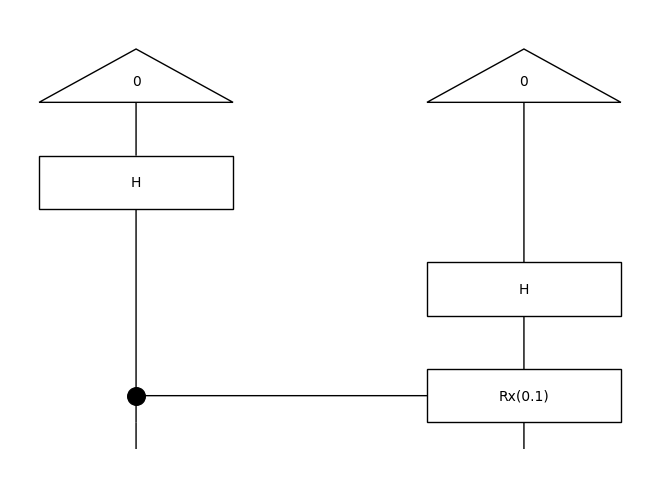

In [29]:
ansatz_cod_len_2(0.1).draw()

In [30]:
counter = -1
m = 1

In [31]:
s, n, p = Ty('s'), Ty('n'), Ty('p')
def cnot_ob(ty):
    # this implicitly maps all rigid types to 1 qubit
    return qubit ** len(ty)
def cnot_ar(box):
    global counter
    codomainlist = []
    for el in list(box.cod):
        codomainlist.append(str(el))
    cod = len(box.cod)
    box_name = str(box)
    counter += 1
    if cod == 1 and counter != m:
        return ansatz_cod_len_1(params[box_name])
    elif cod == 1 and counter == m:
        return ansatz_cod_len_1_masked()

    elif cod == 2 and counter != m and 'xxx' not in codomainlist:
        return ansatz_cod_len_2(params[box_name])
    elif cod == 2 and counter == m and 'xxx' not in codomainlist:
        return ansatz_cod_len_2_masked()

    elif cod == 3 and counter != m and 'xxx' not in codomainlist:
        return ansatz_cod_len_3(params[box_name])
    elif cod == 3 and counter == m and 'xxx' not in codomainlist:
        return ansatz_cod_len_3_masked()
    #elif cod == 3 and counter != m and 'xxx' in codomainlist:
    #    return ansatz_cod_len_2(params[box_name])
    #elif cod == 3 and counter == m and 'xxx' not in codomainlist:
    #    return ansatz_cod_len_2_masked()

    elif cod == 4 and counter != m and 'xxx' not in codomainlist:
        return ansatz_cod_len_4(params[box_name])
    elif cod == 4 and counter == m and 'xxx' not in codomainlist:
        return ansatz_cod_len_4_masked()
    #elif cod == 4 and counter != m and 'xxx' in codomainlist:
     #   return ansatz_cod_len_3(params[box_name])
    #elif cod == 4 and counter == m and 'xxx' in codomainlist:
      #  return ansatz_cod_len_3_masked()

    elif cod == 5 and counter != m and 'xxx' not in codomainlist:
        return ansatz_cod_len_5(params[box_name])
    elif cod == 5 and counter == m and 'xxx' not in codomainlist:
        return ansatz_cod_len_5_masked()
    #elif cod == 5 and counter != m and 'xxx' in codomainlist:
    #    return ansatz_cod_len_4(params[box_name])
    #elif cod == 5 and counter == m and 'xxx' in codomainlist:
    #    return ansatz_cod_len_4_masked()

def generate_functor():
    Func = CircuitFunctor(
    ob=cnot_ob,
    ar=cnot_ar)
    return Func
#{s: qubit ** 0, n: qubit ** 1}

In [42]:
data = []
def build_data():
    """
    We build a data list in form of: [[sen, masked sen, eval of sen with random params], ...]
    :return:
    """
    for tuple in corpus:
        data_point = []

        #Append the tuple
        data_point.append(tuple)

        #Get the evaluation of the origin sentence
        circ = generate_functor()(parser.sentence2diagram(tuple[0]))
        circ_eval = Circuit.eval(
            circ,
            backend=AerBackend(),
            n_shots=1024,
            seed=1,
            compilation=AerBackend().default_compilation_pass(2))
        data_point.append(np.abs(circ_eval.array))
        data.append(data_point)
build_data()
data

[[('cat runs after mouse', 0), 0.019434166531034757],
 [('seal runs on land', 0), -0.044829670022089305],
 [('dog chases after fox', 3), -0.018223198436741354],
 [('dog barks at fox', 0), 0.06652068592462837],
 [('whale eats krill', 2), 0.12008797305703581],
 [('fox flees dog', 2), -0.17990698369682961],
 [('dog barks at fox', 3), 0.06652068592462837],
 [('seal swims in water', 3), 0.031077169350769623],
 [('chicken runs on land', 3), 0.08631693350794388],
 [('dog bites bone', 2), 0.2430586227977528],
 [('fox chases after chicken', 3), 0.008257238446008773],
 [('cat eats fish', 1), 0.14378919029050613],
 [('dog bites cat', 1), -0.055490500549771025],
 [('chicken flees fox', 1), -0.1451089245431463],
 [('mouse squeaks', 1), 0.49762483302986227],
 [('cat meows', 1), -0.43875917902390776],
 [('fish swims', 1), 0.10888242325900369],
 [('fox chases after chicken', 1), 0.008257238446008773],
 [('fish swims in water', 1), -0.03157075554467316],
 [('cat chases after mouse', 2), -0.009752866972

In [19]:
test_dict = defaultdict()
def build_test_dict():
    for data_point in corpus:
        sen = data_point[0]
        if sen not in test_dict.keys():
            dia = generate_functor()(parser.sentence2diagram(sen))
            circ_eval = Circuit.eval(
                dia,
                backend=AerBackend(),
                n_shots=1024,
                seed=1,
                compilation=AerBackend().default_compilation_pass(2))
            test_dict[sen] = np.abs(circ_eval.array)
build_test_dict()
test_dict

defaultdict(None, {'Alice loves Bob': 0.02343750000000001})

In [20]:
'''
from pytket.extensions.qiskit import tk_to_qiskit, AerBackend
tk_circ = circuit.to_tk()
tk_to_qiskit(tk_circ).draw()
'''

'\nfrom pytket.extensions.qiskit import tk_to_qiskit, AerBackend\ntk_circ = circuit.to_tk()\ntk_to_qiskit(tk_circ).draw()\n'

In [37]:
epochs = 1500
lr = 0.5

In [34]:
def loss(y_true, y_pred):
    return 2*(y_pred - y_true)

In [35]:
def update(loss, updating_params):
    for param in updating_params:
        params[param] = params[param.strip()] - lr * loss

In [38]:
def train():
    for _ in range(epochs):
        for data_point in data:
            sen = data_point[0][0]

            global m
            m=data_point[0][1]

            y_true = data_point[1]

            global counter
            counter = -1
            circ = generate_functor()(parser.sentence2diagram(sen))
            circ_eval = Circuit.eval(
                circ,
                backend=AerBackend(),
                n_shots=1024,
                seed=1,
                compilation=AerBackend().default_compilation_pass(2))
            qugit = np.abs(circ_eval.array)
            ls = loss(y_true, qugit)
            updating_params = []
            for token in word_tokenize(sen):
                if word_tokenize(sen).index(token) != m:
                    updating_params.append(str(token))
            update(ls, updating_params)
            print(ls)


In [39]:
train()

0.07555296239449845
8.625209314730026e-05
0.12869955243772685
0.016939085623276687
0.011273242753363763
0.6211888093134056
0.01891056105145205
1.4981131018677777e-06
0.00014411613557243497
0.05088467431634792
0.2539173607505197
0.022015745839283042
0.3572214780712262
0.13713380907040207
5.6414181360327264e-06
0.7454833326588152
1.1570334900327766
0.05886468538129005
0.0006417960539169679
0.03309590755645572
0.0005025296821223641
0.0002709608964939131
0.24511187320661615
0.20170359391800705
0.0014497006937380444
0.16228280242823634
0.01696935799688395
0.010105563134203884
0.3425729089508743
0.04714569513050493
1.2118779731921564e-06
0.0008148823928602324
0.006881709423032313
0.23446945733711919
0.0830431357922781
0.34135619155025554
0.3860051140085603
5.6414181360327264e-06
1.129519518459204
0.7795829282302186
0.04870443249632393
0.0002944748203434843
0.12276855420334573
0.003455919969376888
0.0015881177215391364
0.38059684400253757
0.24298978172364866
0.006135762215222694
0.38160920754

In [19]:
params

defaultdict(<function __main__.<lambda>()>,
            {'cat': -24.25197023359427,
             'runs': -2.0672106003854913,
             'after': 0.10963935743642557,
             'mouse': -8.338828635067694,
             'seal': 0.23336815267351996,
             'on': -0.6288799271493634,
             'land': -0.6315492787621212,
             'dog': -0.06303116466877541,
             'chases': 0.009183821201479777,
             'fox': -4.421771848881009,
             'barks': 0.3234732330829099,
             'at': -0.3256510810192718,
             'whale': 0.2910314865497611,
             'eats': 0.5990769626658575,
             'krill': 0.17467023211725397,
             'flees': -0.21067602651194514,
             'swims': 0.5715823579695053,
             'in': -0.054063983324742514,
             'water': 0.2481050579626716,
             'chicken': -4.7551223978484085,
             'bites': 0.4165720767142184,
             'bone': 0.8625503409694907,
             'fish': -23.8547230

In [40]:
data_test=[('Alice loves Bob', 2)]

In [41]:
def test(data_test):
    for data_point in data_test:
       sen = data_point[0]
       test_sen = generate_functor()(parser.sentence2diagram(sen))
       test_sen_eval = Circuit.eval(test_sen,
                backend=AerBackend(),
                n_shots=1024,
                seed=1,
                compilation=AerBackend().default_compilation_pass(2))
       print(np.abs(test_sen_eval.array) - test_dict[sen])
test(data_test)

0.14378919029050613


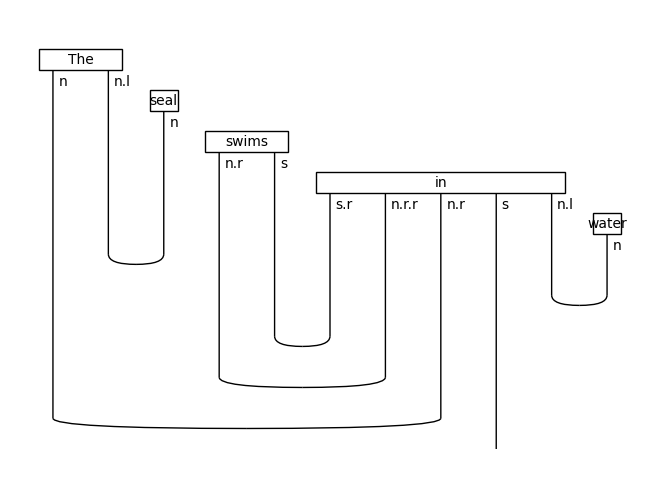

In [351]:
params['cat']=0.7
params['loves'] = 0.9
params['chases']=0.89

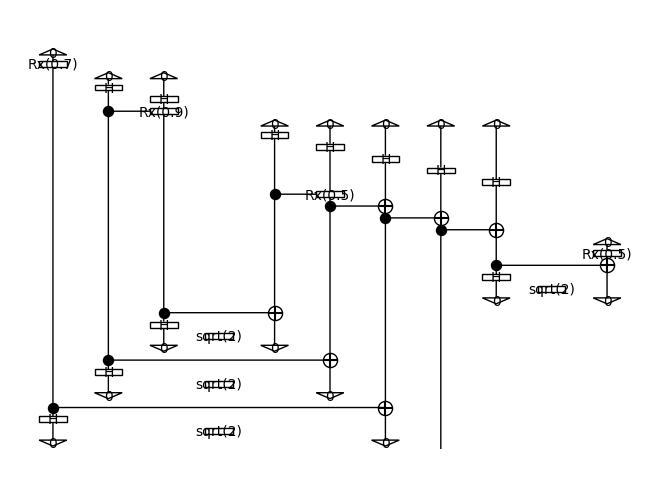

[0.0371945+0.01208523j 0.0371945+0.01208523j]
[0.03910862 0.03910862]
[0.0371945 0.0371945]


In [352]:

circ = generate_functor()(parser.sentence2diagram('cat swims in ocean'))
circ.draw()
result = circ.eval()
print(result.array)
print(abs(result.array))
print(result.array.real)


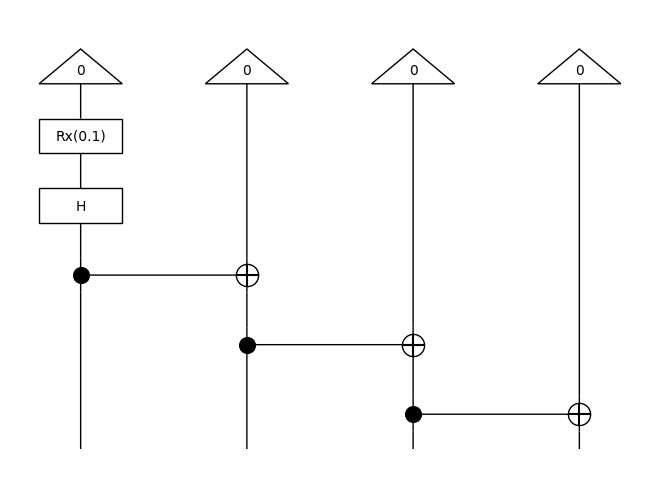

{Alice__n, Bob__n, loves__n.r@s@n.l}